In [ ]:
import numpy as np
import random
import gym
import torch
from torch.nn import Sequential, Linear, ReLU
from torch.nn.functional import mse_loss
from collections import deque
from torch import optim
from tqdm import tqdm

import pyglet

In [ ]:
enviroment = gym.make("MountainCar-v0")
print(enviroment.action_space)
print(enviroment.observation_space)

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [ ]:
class DeepQLearning:
    def __init__(self, env, linear_dim=32, lr=0.005, games=200):
        self.env = env
        # Количество игр (запусков машинки)
        self.games = games
        
        # Количество действий
        self.action_num = env.action_space.n
        
        # Количество показателей, описывающих состояние
        self.state_num = env.observation_space.shape[0]
        
        # 2 скрытых слоя по 32 нейрона, после них - функии активаци ReLu
        # на выходе мы получаем оценку Q-функции: Q(s, a1), Q(s, a2), Q(s, a3)
        self.model = Sequential(
                         Linear(self.state_num, linear_dim),
                         ReLU(),
                         Linear(linear_dim, linear_dim),
                         ReLU(),
                         Linear(linear_dim, self.action_num)
        )
        
        # Оптимизатор для градиентного спуска
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, gamma=0.99, eps=0.5, batch_size=128, memory_size=10000, k_r=1000):
        def choose_action():
            random_action = random.randint(0, self.action_num - 1)
            return random_action if random.random() < eps else output.argmax().item()

        memory = deque(maxlen=memory_size)
        # env.reset() — завершает текущий эпизод и начинает новый. Возвращает начальное состояние.
        state = self.env.reset()
        games_rewards = []

        for game in tqdm(range(self.games)):
            total_reward = 0
            done = False

            while not done:
                # if (game > 180):
                #     self.env.render()
                output = self.model(torch.tensor(state).float())

                # e-greedy политика. Выбираем жадно, по max; иногда выбираем случайно - "exploration"
                action = choose_action()

                # env.step(action) — совершает указанное действие.
                # Возвращает новое состояние, награду, завершился ли эпизод и дополнительную информацию,
                # которую можно использовать для дебага
                next_state, reward, done, _ = self.env.step(action)
                # reward shaping
                # На каждом шаге наш агент получает награду -1, и так происходит до тех пор, пока не завершится эпизод
                # 1) (добавим модуль скорости с некоторым коэффициентом к награде)
                # 2) есть класс «безопасных» изменений, которые основаны на методе потенциалов. Воспользуемся:
                modified_reward = reward + k_r * (gamma * abs(next_state[1]) - abs(state[1]))
                
                # Загружаем в память
                # Структура памяти:
                # [состояние - новое состояние - награда - закончили? - действие]
                memory.append((state, next_state, modified_reward, done, action))
                total_reward += reward
                if done:
                    games_rewards.append(total_reward)
                    state = self.env.reset()
                else:
                    state = next_state


                if len(memory) > batch_size:
                    batch = list(zip(*random.sample(list(memory), batch_size)))
                    state_batch = torch.tensor(batch[0]).float()
                    next_state_batch = torch.tensor(batch[1]).float()
                    reward_batch = torch.tensor(batch[2]).float()
                    done_batch = torch.tensor(batch[3])
                    action_batch = torch.tensor(batch[4])
                    
                    with torch.no_grad():
                        # Выбираем максимальное из значений Q-function для следующего состояния
                        target_q, _ = self.model(next_state_batch).max(dim=1)
                        target_q[done_batch] = 0

                    target_q = reward_batch + gamma * target_q
                    
                    # Текущее предсказание
                    q = self.model(state_batch).gather(dim=1, index=action_batch.unsqueeze(dim=1)).squeeze()
                    
                    # Градиентный спуск
                    self.optimizer.zero_grad()
                    mse_loss(q, target_q).backward()

                    self.optimizer.step()

            # обновляем для e-greedy политики
            eps = max(0.05, eps - eps * (game / self.games))

        return games_rewards

In [ ]:
N_AGENTS = 9
all_games = []

for _ in range(N_AGENTS):
    dq = DeepQLearning(enviroment)
    games_rewards = dq.train()
    all_games.append(games_rewards)

mean_games_rewards = np.array(all_games).mean(axis=0)

100%|██████████| 200/200 [01:07<00:00,  2.94it/s]


No handles with labels found to put in legend.


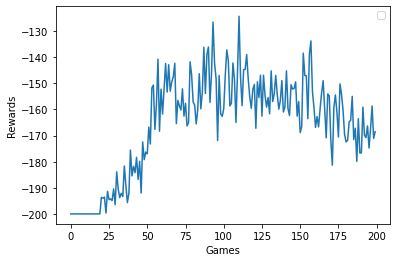

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
plt.plot(range(len(mean_games_rewards)), mean_games_rewards)
ax.set_xlabel("Games")
ax.set_ylabel("Rewards")
plt.legend()
enviroment.close()

## Game example (around 190)

![Alt text](https://drive.google.com/uc?export=view&id=1SfycvDZvRT6Bxj4hCcUm0c4UF1mn8z6g)